In [5]:
import numpy as np
import matplotlib.pyplot as plt

import mmd as mmd
import operators as myops
import lasso as ls
import continuous_BP as cbp

from helper import prune,generate_plots

import matplotlib.pyplot as plt

from importlib import reload  # Python 3.4+
reload(myops)
reload(mmd)

<module 'mmd' from '/Users/u2272691/Documents/GitHub/continuous-BP/Python/cBP_paper/mmd.py'>

In [6]:

error_fun = lambda x,a,y,b : mmd.mmd_laplace(x[:,None],a, y[:,None],b)

#reconstruction grid and operator
def get_discretized_op(N, mtype='Gaussian'):
    if mtype=='Gaussian':
        m =  20 #number of observed points
        sigma = 0.05
        tvec = np.linspace(0,1,m) #observed points
        x0,x1=0,1 
        xgrid = np.linspace(x0,x1,N) #reconstruction grid
        Phi, A, dA = myops.getGaussianMatrices(tvec,sigma,xgrid)
    
    elif mtype=='Fourier':
        #Fourier
        fq = 10
        x0,x1=0,1
        xgrid = np.linspace(x0,x1,N)
        Phi,  A, dA = myops.getFourierMatrices(fq,xgrid)
    elif mtype == 'Laplace':
        T = 20
        x0,x1=0,8
        tvec = np.linspace(x0,x1,T)
        xgrid = np.linspace(x0,x1,N)
        Phi, A, dA = myops.getLaplaceMatrices(tvec,xgrid)
        
    return xgrid, A, dA,Phi



def generate_random_signal(s,N,shift,Phi, noise, minsep=1,pos=True):    
    P = np.random.permutation(N//minsep)
    idx = P[:s]*minsep
    
    #idx = np.random.randint(minsep, 3*minsep, (s,))
    #idx = np.mod(np.cumsum(idx), N)
    t0 = xgrid[idx] + shift
    if pos:
        a = np.random.rand(s,)+2
    else:
        a = (np.random.rand(s,)+2)*np.sign(np.random.randn(s,))+1j* (np.random.rand(s,)+2)*np.sign(np.random.randn(s,))
    
    y_true = Phi(t0)@a
    noise_lev = noise*np.linalg.norm(y_true)/np.sqrt(len(y_true))
    y_obs = y_true +noise_lev*np.random.randn( *y_true.shape) 
    return t0, a, y_obs



Define parameters

In [7]:
#Gaussian
mtype = 'Fourier'
#mtype = 'Gaussian'

pos = False

N=50 #discretization
xgrid, A, dA,Phi = get_discretized_op(N,mtype=mtype)

#signal parameters
spacing=0.2
h=xgrid[1]-xgrid[0]
s = 4 #signal sparsity

tau= 1 #parameter for SR Lasso

tol=1e-2




Run on one instance

0.06331028989083731 0.32409240465197026
5 12


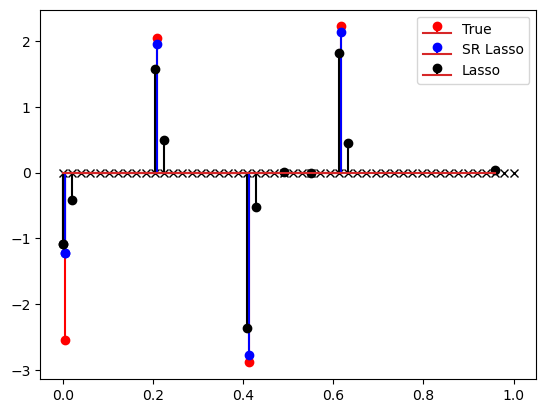

In [8]:

alpha = 0.1
t0,a0,y_obs = generate_random_signal(s,N,spacing*h,Phi, 0.01, minsep=N//5,pos=pos)

if pos:
    #run cBP
    a_cbp, shift_cbp= cbp.cBP_1D( A, dA, h, y_obs,alpha )
    a_cbp, x_cbp = prune(a_cbp, shift_cbp + xgrid,tol)
    if mtype=='Fourier':
        x_cbp = np.mod(x_cbp,1)
    
    print('cbp error',error_fun(t0,a0,x_cbp,a_cbp))

# run SR Lasso
a,shift = cbp.SRLasso(A, dA, y_obs,alpha,tau)
a_srl, x_srl = prune(a, xgrid+shift, tol)
if mtype=='Fourier':
    x_srl = np.mod(x_srl,1)
#run Lasso
a = ls.groupLasso(A, y_obs,alpha,1)
a_lasso, x_lasso = prune(a, xgrid, tol)
if mtype=='Fourier':
        x_lasso = np.mod(x_lasso,1)

plt.stem(t0,a0,'r',label='True')
plt.plot(xgrid,xgrid*0,'kx')
plt.stem(x_srl,a_srl,'b',label='SR Lasso')
if pos:
    plt.stem(x_cbp,a_cbp,'g',label='CBP')
plt.stem(x_lasso,a_lasso,'k',label='Lasso')

plt.legend()

print(error_fun(t0,a0,x_srl,a_srl) ,error_fun(t0,a0,x_lasso,a_lasso) )
print(len(a_srl),len(a_lasso))


/Users/u2272691/Documents/GitHub/continuous-BP/Python/cBP_paper/continuous_BP.py:57: RuntimeWarning: invalid value encountered in divide
  shift = b/a


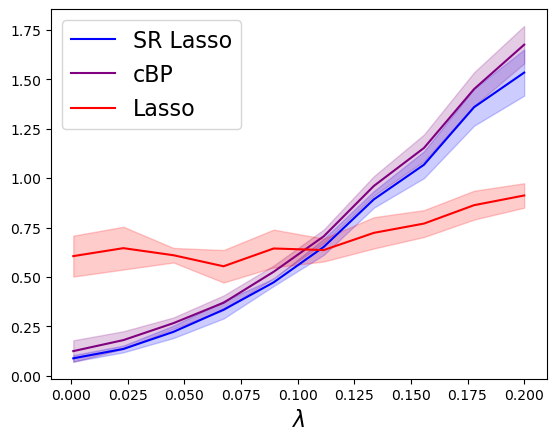

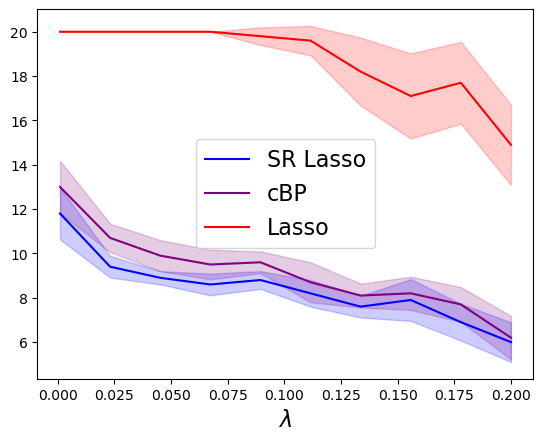

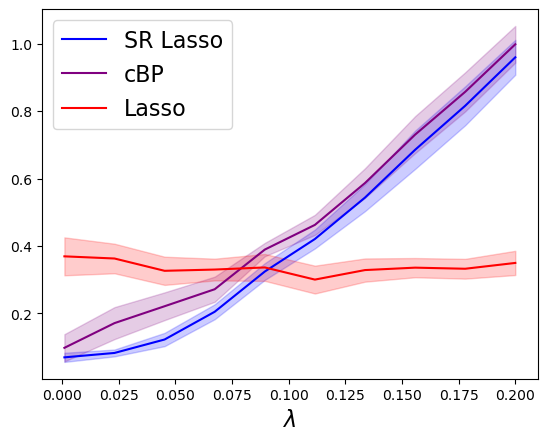

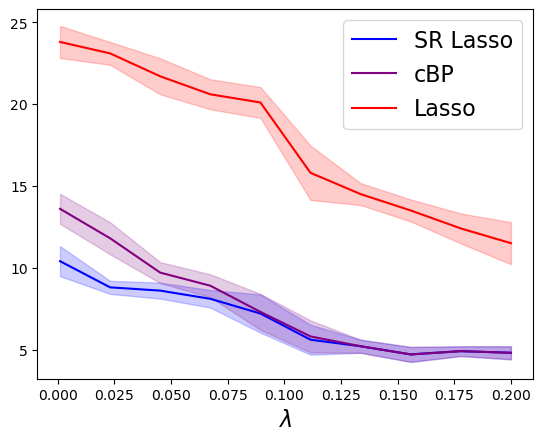

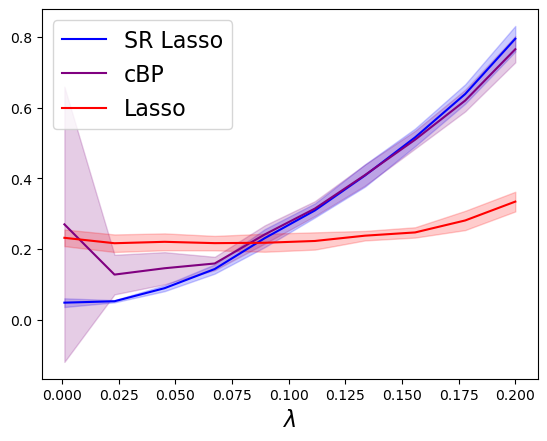

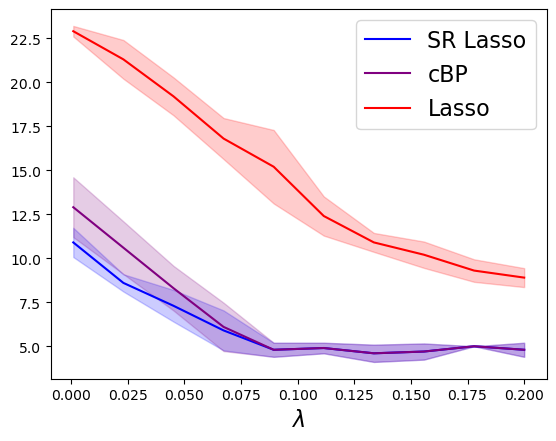

In [9]:
#Gaussian
mtype = 'Fourier'
#mtype = 'Gaussian'

pos = True
N_vals = [20,30,40] #discretization

for N in N_vals:

    xgrid, A, dA,Phi = get_discretized_op(N,mtype=mtype)

    #signal parameters
    spacing=0.2
    h=xgrid[1]-xgrid[0]
    s = 4 #signal sparsity
    tau= 1 #parameter for SR Lasso
    tol=1e-2


    #range of regularisation parameter
    Runs = 10
    L= 10
    alpha_max = .2
    alpha_vals = np.linspace(1e-3,alpha_max,L)

    #record errors
    err_lasso =  np.zeros((L,Runs))
    err_cbp = np.zeros((L,Runs))
    err_srlasso = np.zeros((L,Runs))
    supp_lasso = np.zeros((L,Runs))
    supp_cbp = np.zeros((L,Runs))
    supp_srlasso = np.zeros((L,Runs))

    for i in range(L):
        alpha = alpha_vals[i]

        for r in range(Runs):
            t0,a0,y_obs = generate_random_signal(s,N,spacing*h,Phi, 0.01, minsep=N//5,pos=pos)

            #run cBP
            if pos:
                a_cbp, shift_cbp= cbp.cBP_1D( A, dA, h, y_obs,alpha )
                a_cbp, x_cbp = prune(a_cbp, shift_cbp + xgrid,tol)
                if mtype=='Fourier': 
                    x_cbp = np.mod(x_cbp,1)
                err_cbp[i,r] = error_fun(t0,a0,x_cbp,a_cbp) 
                supp_cbp[i,r] = len(a_cbp)

            # run SR Lasso
            a,shift = cbp.SRLasso(A, dA, y_obs,alpha,tau)
            a_srl, x_srl = prune(a, xgrid+shift, tol)

            #run Lasso
            a = ls.groupLasso(A, y_obs,alpha,1)
            a_lasso, x_lasso = prune(a, xgrid, tol)

            #recovered positions should be in [0,1] if Fourier
            if mtype=='Fourier':
                x_srl = np.mod(x_srl,1)
                x_lasso = np.mod(x_lasso,1)

            #record errors
            err_srlasso[i,r] = error_fun(t0,a0,x_srl,a_srl) 
            supp_srlasso[i,r] = len(a_srl)

            err_lasso[i,r] = error_fun(t0,a0,x_lasso,a_lasso) 
            supp_lasso[i,r ] = len(a_lasso)
            
            
    #Plot the error    
    if pos:
        Plots = [err_srlasso,err_cbp,err_lasso]
        labels = ['SR Lasso','cBP','Lasso']

        Plots_supp = [supp_srlasso,supp_cbp,supp_lasso]
    else:
        Plots = [err_srlasso,err_lasso]
        labels = ['SR Lasso','Lasso']
        Plots_supp = [supp_srlasso,supp_lasso]

    results_dir = 'results/test/'
    filename = mtype+'N'+str(N)+'s'+str(s)+'_pos='+str(pos)+'.png'
    generate_plots(Plots, labels, results_dir+'Err_'+ filename,
                   xaxis=alpha_vals, xlabel='$\lambda$')
    generate_plots(Plots_supp, labels, results_dir+'Supp_'+ filename,
                   xaxis=alpha_vals,xlabel='$\lambda$')
    

            
